In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from IPython.display import clear_output

# CHANGE THIS
FOLDERNAME = "programming/nlp/"
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/programming/nlp


# Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.layers import Conv1D, GlobalMaxPooling1D


In [ ]:
df = pd.read_csv('dataset/shopee_sentiment/train_preprocess_unsegment.csv')
df.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)
df.head()

,id,class,preprocess_text
0,dee6dfc5,1,đến quán 2 lần thôi rất là thích quán tuy nằm ...
1,800813f5,0,đến quán vào tối chủ nhật có band hát khá ổn t...
2,6553e47f,0,phục vụ lâu quá mặc dù khách rất vắng đợi gần ...
3,b45a1ff1,0,ko gian bé tí quán chật chội đông người nên ...
4,f92694b0,1,khi mình order đặt bánh thì nhận được sự tiếp ...


# Word2Vec

## 1 Input
We are going to train CBOW and SKIP-GRAm using Gensim.Word2Vec

First, we have to labelize each sentence by unique id: all_words0, all_words1

In [ ]:
def labelize(sentences, label):
  result = []
  prefix = label
  for i, t in zip(sentences.index, sentences):
      result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
  return result
X = df.preprocess_text
Y = df['class']

X_w2v = labelize(X, 'all_words')

## 2 CBOW concat SKIP-GRAM + Logistic Regression
Each model are trained with 50 epochs

In [ ]:
cores = multiprocessing.cpu_count()

model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(X_w2v)])
for epoch in range(50):
  model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(X_w2v)]),
                      total_examples=len(X_w2v), epochs=1)
  model_ug_cbow.alpha -= 0.002
  model_ug_cbow.min_alpha = model_ug_cbow.alpha


model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(X_w2v)])
for epoch in range(50):
  model_ug_sg.train(utils.shuffle([x.words for x in tqdm(X_w2v)]),
                      total_examples=len(X_w2v), epochs=1)
  model_ug_sg.alpha -= 0.002
  model_ug_sg.min_alpha = model_ug_sg.alpha

In [ ]:
model_ug_cbow.wv.save('dataset/shopee_sentiment/model_cbow.model')
model_ug_sg.wv.save('dataset/shopee_sentiment/model_sg.model')


### CBOW concat SKIP-GRAM + Logistic Regression 

### 1 get_w2v_mean()
Right now each word can be represented by 2 vectors: cbow and skip-gram, each has shape (100, )

We concat it to create a vector of shape (200, ). Then we normalize each by divide it to the size of the sentence

* The reason why we append cbow and skip-gram can be seen later in the notebook. But for now, validation accuracy increase when we concat them together
* I am not sure about this normalization and haven't tried the results if we don't normalize


In [ ]:
def get_w2v_mean(sentence, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in sentence.split():
      try:
          vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
          count += 1.
      except KeyError:
          continue
  if count != 0:
      vec /= count
  return vec


### 2
Input to this function is dataframe X and dataframe Y

We are using KFold cross-validation with k = 5

Firstly, we convert the data into numpy array. Then convert to vectors with the previous get_w2v_mean function

Secondly, we scale them so that the vector has zero-mean, unit-variance

Finally, we train it using logistic regression

In [ ]:
def lr_cv(splits, X, Y, average_method):
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
  accuracy = []
  precision = []
  recall = []
  f1 = []
  for train, test in kfold.split(X, Y):
    Y[train] = Y[train].to_numpy()
    Y[test] = Y[test].to_numpy()

    train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X[train]]))
    test_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X[test]]))

    clf.fit(train_vecs_cbowsg_mean, Y[train])
    prediction = clf.predict(test_vecs_cbowsg_mean)
    scores = clf.score(test_vecs_cbowsg_mean, Y[test])

    accuracy.append(scores * 100)
    precision.append(precision_score(Y[test], prediction, average=average_method)*100)
    print('            1            2')
    print('precision:',precision_score(Y[test], prediction, average=None))
    recall.append(recall_score(Y[test], prediction, average=average_method)*100)
    print('recall:   ',recall_score(Y[test], prediction, average=None))
    f1.append(f1_score(Y[test], prediction, average=average_method)*100)
    print('f1 score: ',f1_score(Y[test], prediction, average=None))
    print('-'*50)

  print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
  print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
  print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
  print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

  ConfusionMatrixDisplay.from_estimator(clf, test_vecs_cbowsg_mean, Y[test])
  plt.show()

In [ ]:
clf = LogisticRegression()
lr_cv(5, X, Y, 'macro')

### 3
Just by using CBOW concat SKIP-GRAM we get the validation accuracy of 86.54%, pretty good.

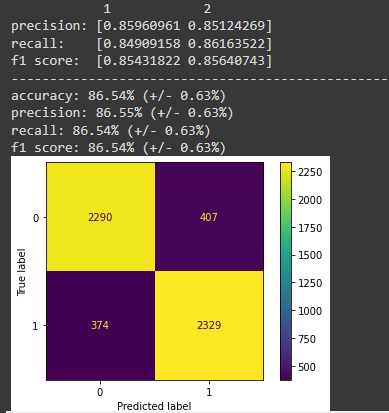

## CBOW concat SKIP-GRAM + Neural network

### 1 
For neural network model, prepare data by splitting them into train, val and test

In [ ]:
x = df.preprocess_text
y = df['class']
from sklearn.model_selection import train_test_split
SEED = 2000
X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
print("Train set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% positive".format(
    len(X_train), 
    (len(X_train[y_train == 0]) / (len(X_train)*1.))*100, 
    (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))
print("Validation set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% positive".format(
    len(X_val), 
    (len(X_val[y_val == 0]) / (len(X_val)*1.))*100, 
    (len(X_val[y_val == 1]) / (len(X_val)*1.))*100))
print("Test set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% positive".format(
    len(X_test),
    (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Train set has total 26460 entries with 
 50.00% negative, 50.00% positive
Validation set has total 270 entries with 
 45.93% negative, 54.07% positive
Test set has total 270 entries with 
 47.78% negative, 52.22% positive


### 2 
Before this step, y has shape of (batch_size, 1) with values in range (0, 1)

After this step, y has shape (batch_size, 2) with values of one-hot vector

This is important for calculating recall, precision, f1

In [ ]:
y_train, y_val, y_test = y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()

y_train = np.int32(to_categorical(y_train))
y_val = np.int32(to_categorical(y_val))
y_test = np.int32(to_categorical(y_test))


In [ ]:
train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_train]))
val_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_val]))
test_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_test]))

### 3
Functions to calcuate recall, precision, f1

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### 4
Define a keras sequential model with early_stop flag

Note that training step stop very soon, which implies that our CBOW/SKIP-GRAM vectors are good enough

Result: val accuracy: 87% - val f1: 86%

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
seed = 7
np.random.seed(seed)

filepath="dataset/shopee_sentiment/w2v_01_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint]
callbacks_list = [checkpoint, early_stop]

model_01 = Sequential()
model_01.add(Dense(256, activation='relu', input_dim=200))
model_01.add(Dense(256, activation='relu'))
model_01.add(Dense(256, activation='relu'))
model_01.add(Dense(2, activation='sigmoid'))
model_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

model_01.fit(train_vecs_cbowsg_mean, y_train, validation_data=(val_vecs_cbowsg_mean, y_val), 
                 epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)


Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.85926, saving model to dataset/shopee_sentiment/w2v_01_best_weights.hdf5
827/827 - 4s - loss: 0.3523 - acc: 0.8564 - f1_m: 0.8563 - precision_m: 0.8570 - recall_m: 0.8558 - val_loss: 0.2975 - val_acc: 0.8593 - val_f1_m: 0.8591 - val_precision_m: 0.8591 - val_recall_m: 0.8591 - 4s/epoch - 5ms/step
Epoch 2/100

Epoch 00002: val_acc improved from 0.85926 to 0.90000, saving model to dataset/shopee_sentiment/w2v_01_best_weights.hdf5
827/827 - 3s - loss: 0.3056 - acc: 0.8755 - f1_m: 0.8756 - precision_m: 0.8752 - recall_m: 0.8760 - val_loss: 0.3046 - val_acc: 0.9000 - val_f1_m: 0.9015 - val_precision_m: 0.9036 - val_recall_m: 0.8998 - 3s/epoch - 3ms/step
Epoch 3/100

Epoch 00003: val_acc did not improve from 0.90000
827/827 - 3s - loss: 0.2857 - acc: 0.8834 - f1_m: 0.8829 - precision_m: 0.8831 - recall_m: 0.8828 - val_loss: 0.2971 - val_acc: 0.8963 - val_f1_m: 0.8954 - val_precision_m: 0.8972 - val_recall_m: 0.8938 - 3s/epoch - 3ms/st

In [ ]:
model_01.save('dataset/shopee_sentiment/w2v_neural_network.h5')


In [ ]:
loss, accuracy, f1_score, precision, recall = model_01.evaluate(X_test, y_test, batch_size=32, verbose=2)
print('Test accuracy: ',accuracy * 100)

In [ ]:
y_pred = model_01.predict(test_vecs_cbowsg_mean)
print(confusion_matrix(y_pred, y_test))


[[106  23]
 [ 23 118]]


### 5 
Test with an example

It predicts positive

In [ ]:
sentence = 'cái áo này đẹp'
sentence_vector = get_w2v_mean(sentence, 200)
prediction = model_01.predict(sentence_vector).argmax(axis=1)
print(prediction)

[1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## CBOW concat SKIP-GRAM + CNN

### 0 Preparation

In [ ]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('dataset/shopee_sentiment/model_cbow.model')
model_ug_sg = KeyedVectors.load('dataset/shopee_sentiment/model_sg.model')


In [ ]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
clear_output()

### 1 
First, fit the data with a Tokenizer

Suppose a sentence 'I am a student'

The tokenizer creates a dictionary:

{'I': 1, 'am': 2, 'a': 3, 'student': 4}

Each word in the dataset are replaced by the index in the dictionary

In [ ]:

num_words = len(X_train)
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=45)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=45)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=45)

In [ ]:
tokenizer.word_index.items()

dict_items([('mình', 1), ('ăn', 2), ('có', 3), ('là', 4), ('không', 5), ('quán', 6), ('thì', 7), ('và', 8), ('cũng', 9), ('ngon', 10), ('rất', 11), ('mà', 12), ('nhưng', 13), ('ở', 14), ('nên', 15), ('đây', 16), ('lại', 17), ('món', 18), ('đi', 19), ('thấy', 20), ('1', 21), ('viên', 22), ('ko', 23), ('được', 24), ('nhân', 25), ('với', 26), ('giá', 27), ('như', 28), ('bánh', 29), ('bạn', 30), ('cho', 31), ('này', 32), ('đến', 33), ('ra', 34), ('nói', 35), ('vụ', 36), ('lần', 37), ('quá', 38), ('uống', 39), ('khá', 40), ('còn', 41), ('đồ', 42), ('phục', 43), ('nhiều', 44), ('nước', 45), ('cả', 46), ('phải', 47), ('vị', 48), ('của', 49), ('cái', 50), ('vào', 51), ('hơi', 52), ('nữa', 53), ('thích', 54), ('khách', 55), ('luôn', 56), ('gọi', 57), ('gian', 58), ('mới', 59), ('người', 60), ('rồi', 61), ('lắm', 62), ('các', 63), ('để', 64), ('chỉ', 65), ('sẽ', 66), ('2', 67), ('vì', 68), ('trà', 69), ('k', 70), ('trong', 71), ('nào', 72), ('làm', 73), ('một', 74), ('hơn', 75), ('gì', 76), ('ng

### 2
Create embedding matrix(Look-Up-Table) for each word

After embedding, each word has shape (200, )

In [ ]:
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
y_train, y_val, y_test = y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()

y_train = np.int32(to_categorical(y_train))
y_val = np.int32(to_categorical(y_val))
y_test = np.int32(to_categorical(y_test))

### 3
Define a sequential model with Conv1D layer

Result: Test accuracy:  83.70370268821716%

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
seed = 7
np.random.seed(seed)

filepath="dataset/shopee_sentiment/w2v_02_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint]

model_02 = Sequential()
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_02.add(e)
model_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_02.add(GlobalMaxPooling1D())
model_02.add(Dense(256, activation='relu'))
model_02.add(Dense(2, activation='sigmoid'))
model_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
model_02.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=2)

model_02.save('dataset/shopee_sentiment/w2v_cnn.h5')

loss, accuracy, f1_score, precision, recall = model_02.evaluate(X_test, y_test, batch_size=32, verbose=2)
print('Test accuracy: ',accuracy * 100)

y_pred = model_02.predict(X_test)
print(confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1)))

In [ ]:
loss, accuracy, f1_score, precision, recall = model_02.evaluate(X_test, y_test, batch_size=32, verbose=2)
print('Test accuracy: ',accuracy * 100)

9/9 - 0s - loss: 1.0145 - accuracy: 0.8370 - 55ms/epoch - 6ms/step
Test accuracy:  83.70370268821716


In [ ]:
y_pred = model_02.predict(X_test)
print(confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1)))

[[102  17]
 [ 27 124]]


### 4
Define a sequential model with 3 Conv1D layer with kernel size of 2, 3, 4 respectively

Output of each Conv1D are then concated. Noted that here we are doing the same thing we did with CBOW and SKIP-GRAM vectors

Result: Test accuracy:  84.07407402992249


In [ ]:

seed = 7
np.random.seed(seed)

filepath="dataset/shopee_sentiment/w2v_03_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint]

input = Input(shape=(45,), dtype='int32')
encoded_input = Embedding(num_words, 200, weights=[embedding_matrix], input_length=45, trainable=True)(input)

bigram_layer = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(encoded_input)
trigram_layer = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(encoded_input)
fourgram_layer = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(encoded_input)

bigram_layer = GlobalMaxPooling1D()(bigram_layer)
trigram_layer = GlobalMaxPooling1D()(trigram_layer)
fourgram_layer = GlobalMaxPooling1D()(fourgram_layer)
merged = concatenate([bigram_layer, trigram_layer, fourgram_layer], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
output = Dense(2, activation='sigmoid')(merged)

model_03 = Model(inputs=[input], outputs=[output])
model_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
model_03.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 45, 200)      5292000     ['input_3[0][0]']                
                                                                                                  
 conv1d_15 (Conv1D)             (None, 44, 100)      40100       ['embedding_7[0][0]']            
                                                                                                  
 conv1d_16 (Conv1D)             (None, 43, 100)      60100       ['embedding_7[0][0]']            
                                                                                              

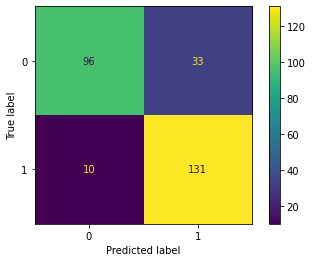

In [ ]:
model_03.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=2)

model_03.save('dataset/shopee_sentiment/w2v_cnn_2.h5')

y_pred = model_03.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), y_pred.argmax(axis=1))


In [ ]:
loss, accuracy, f1_score, precision, recall = model_03.evaluate(X_test, y_test, batch_size=32, verbose=2)
print('Test accuracy: ',accuracy * 100)


9/9 - 0s - loss: 0.8976 - acc: 0.8407 - f1_m: 0.8431 - precision_m: 0.8445 - recall_m: 0.8418 - 400ms/epoch - 44ms/step
Test accuracy:  84.07407402992249


# Fasttext

## Input

### 1
Load model, create Embedding Matrix

Embedding vector has shape (300, )

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
fasttext_model = KeyedVectors.load_word2vec_format('dataset/shopee_sentiment/cc.vi.300.vec', limit=500000)

In [ ]:
num_words = 500000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=45)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=45)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=45)

In [ ]:
y_train, y_val, y_test = y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()

y_train = np.int32(to_categorical(y_train))
y_val = np.int32(to_categorical(y_val))
y_test = np.int32(to_categorical(y_test))

In [ ]:
embeddings_index = {}
for w in fasttext_model.vocab.keys():
    embeddings_index[w] = np.array(fasttext_model[w])
clear_output()

In [ ]:
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
def get_fasttext_vector(sentence, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in sentence.split():
    try:
      vec += np.array(fasttext_model[word].reshape(1, size))
      count += 1.
    except KeyError:
      continue
  if count != 0:
    vec /= count
  return vec



## Fasttest + Logistic Regression

### 1 
Result: val accuracy: 84.5%, f1: 84.5%

In [ ]:
def lr_cv(splits, X, Y, average_method):
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
  accuracy = []
  precision = []
  recall = []
  f1 = []
  for train, test in kfold.split(X, Y):
    X[train] = X[train].to_numpy()
    X[test] = X[test].to_numpy()
    Y[train] = np.int32(Y[train].to_numpy())
    Y[test] = np.int32(Y[test].to_numpy())

    X_train_fasttext = scale(np.concatenate([get_fasttext_vector(z, 300) for z in X[train]]))
    X_test_fasttext = scale(np.concatenate([get_fasttext_vector(z, 300) for z in X[test]]))

    clf.fit(X_train_fasttext, Y[train])
    prediction = clf.predict(X_test_fasttext)
    scores = clf.score(X_test_fasttext, Y[test])

    accuracy.append(scores * 100)
    precision.append(precision_score(Y[test], prediction, average=average_method)*100)
    print('            1            2')
    print('precision:',precision_score(Y[test], prediction, average=None))
    recall.append(recall_score(Y[test], prediction, average=average_method)*100)
    print('recall:   ',recall_score(Y[test], prediction, average=None))

    f1.append(f1_score(Y[test], prediction, average=average_method)*100)
    print('f1 score: ',f1_score(Y[test], prediction, average=None))
    print('-'*50)

  print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
  print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
  print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
  print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

  ConfusionMatrixDisplay.from_estimator(clf, X_test_fasttext, Y[test])
  plt.show()

In [ ]:
X = df.preprocess_text
y = df['class']
clf = LogisticRegression()
lr_cv(5, X, y, 'macro')

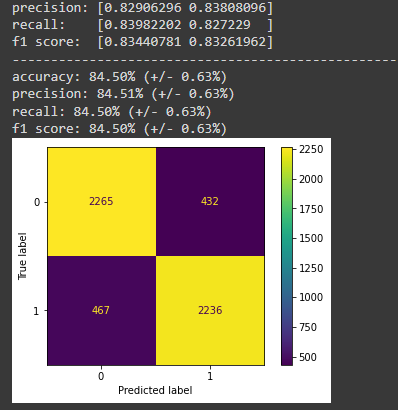

## Fasttest + Convolution

### 1
Result: Test accuracy:  84.44%


In [ ]:
seed = 7
np.random.seed(seed)

filepath="dataset/shopee_sentiment/fasttext_neural_network.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint, early_stop]
# callbacks_list = [checkpoint]

input = Input(shape=(45,), dtype='int32')
encoded_input = Embedding(num_words, 300, weights=[embedding_matrix], input_length=45, trainable=True)(input)

bigram_layer = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(encoded_input)
trigram_layer = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(encoded_input)
fourgram_layer = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(encoded_input)

bigram_layer = GlobalMaxPooling1D()(bigram_layer)
trigram_layer = GlobalMaxPooling1D()(trigram_layer)
fourgram_layer = GlobalMaxPooling1D()(fourgram_layer)
merged = concatenate([bigram_layer, trigram_layer, fourgram_layer], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
output = Dense(2, activation='sigmoid')(merged)

model_04 = Model(inputs=[input], outputs=[output])
model_04.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
model_04.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 45, 300)      150000000   ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 44, 100)      60100       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 43, 100)      90100       ['embedding_2[0][0]']            
                                                                                            

In [ ]:
model_04.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=2)

model_04.save('dataset/shopee_sentiment/fasttext_cnn.h5')

loss, accuracy, f1_score, precision, recall = model_04.evaluate(X_test, y_test, batch_size=32, verbose=2)
print('Test accuracy: ',accuracy * 100)

y_pred = model_04.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), y_pred.argmax(axis=1))
# acc result ~0.84 while acc ~ 0.98

Epoch 1/10
827/827 - 1231s - loss: 0.3782 - acc: 0.8329 - f1_m: 0.8327 - precision_m: 0.8329 - recall_m: 0.8330 - val_loss: 0.3046 - val_acc: 0.8741 - val_f1_m: 0.8770 - val_precision_m: 0.8742 - val_recall_m: 0.8800 - 1231s/epoch - 1s/step
Epoch 2/10
827/827 - 1222s - loss: 0.2440 - acc: 0.9044 - f1_m: 0.9040 - precision_m: 0.9045 - recall_m: 0.9037 - val_loss: 0.3094 - val_acc: 0.8704 - val_f1_m: 0.8680 - val_precision_m: 0.8665 - val_recall_m: 0.8695 - 1222s/epoch - 1s/step
Epoch 3/10


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-152-265aac5689a6>", line 1, in <module>
    model_04.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=2)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/e

KeyboardInterrupt: ignored

In [ ]:
model_04 = keras.models.load_model('dataset/shopee_sentiment/fasttext_cnn.h5', custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m})
loss, accuracy, f1_score, precision, recall = model_04.evaluate(X_test, y_test, batch_size=32, verbose=2)

print('Test accuracy: ',accuracy * 100)


9/9 - 0s - loss: 1.1215 - acc: 0.8444 - f1_m: 0.8497 - precision_m: 0.8497 - recall_m: 0.8497 - 170ms/epoch - 19ms/step
Test accuracy:  84.44444537162781
